## Imports

In [1]:
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
from collections import Counter
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)

try:
    %cd 'Projeto Final/Fruits Classification/CNN/multiclass_classification'
    print('\n')
except:
    pass

!ls
print('\n')

!nvidia-smi

/home/diogo23039/work/2025/PCA/Tratamento de Imagem/Projeto Final/Fruits Classification/CNN/multiclass_classification


best_model.pth	checkpoint.pth	multiclass_CNN.ipynb


Fri Jun 20 07:04:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:01:00.0 Off |                    0 |
| N/A   49C    P0             28W /   70W |    2542MiB /  1

## Checking GPU and CPU

In [2]:
print("Available CPUs:", os.cpu_count())
print("\n--------------------------\n")

if torch.cuda.is_available():
    print(f"Available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"{i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Available CPUs: 128

--------------------------

Available GPUs: 3
0: Tesla T4
1: Tesla T4
2: Tesla T4


## Functions

In [3]:
#####################################################
################### Count Images ####################
#####################################################

def count_images_per_class(dataset, dataset_name):
    class_counts = Counter(dataset.targets)
    print(f"\n{dataset_name} - Number of images per class:")
    for idx, count in sorted(class_counts.items()):
        class_name = dataset.classes[idx]
        print(f"  Class {idx} ({class_name}): {count} images")
        

#####################################################
##################### Metrics #######################
#####################################################

def compute_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


#####################################################
#################### Checkpoint #####################
#####################################################

def save_checkpoint(model, optimizer, history, epoch, path='checkpoint.pth'):
    """Save model, optimizer state and history."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"[Checkpoint] Saved at epoch {epoch+1} → {path}")

def load_checkpoint(model, optimizer, path="checkpoint.pth", device='cpu'):
    """Load model, optimizer state, epoch and history from checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    history = checkpoint['history']
    print(f"[Checkpoint] Loaded from '{path}', resuming at epoch {start_epoch}.")
    return model, optimizer, start_epoch, history


#####################################################
###################### Train ########################
#####################################################

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.long().to(device)  # Para CrossEntropyLoss, labels devem ser long sem one-hot

        optimizer.zero_grad()
        outputs = model(images)  # logits, shape [batch, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * labels.size(0)
        batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

        running_loss += batch_loss
        running_corrects += batch_acc
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def evaluate_model(model, loader, criterion, device, desc="Evaluation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_loss = loss.item() * labels.size(0)
            batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

            running_loss += batch_loss
            running_corrects += batch_acc
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, start_epoch=0, history=None, 
                patience=5, checkpoint_path='checkpoint.pth', best_model_path='best_model.pth'):
    """Main training loop with checkpoint saving and early stopping."""

    if history is None:
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_time': []
        }

    best_val_loss = np.inf
    patience_counter = 0

    model.to(device)

    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, desc="Validation")

        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        # Checkpoint Save
        save_checkpoint(model, optimizer, history, epoch, path=checkpoint_path)

        # Early Stopping Check
        if val_loss < best_val_loss: #(best_val_loss + best_val_loss * 0.05):
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"[EarlyStopping] New best model saved (val_loss: {val_loss:.4f}) → {best_model_path}")
        else:
            patience_counter += 1
            print(f"[EarlyStopping] No improvement... ({patience_counter}/{patience} patience)")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time/60:.2f}min")

        if patience_counter >= patience:
            print(f"[EarlyStopping] Stopping early at epoch {epoch+1}.")
            break

    return history


#####################################################
###################### Evaluate #####################
#####################################################

def evaluate_on_test(model, test_loader, device, class_names=['class0', 'class1', 'class2', 'class3', 'class4']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # logits
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("\nTest Metrics:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1 Score:   {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds, normalize='pred')
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, cmap='Oranges', xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Split)')
    plt.tight_layout()
    plt.show()


#####################################################
####################### Plot ########################
#####################################################

def plot_training_history(history):
    sns.set(style='whitegrid')

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    sns.reset_defaults()

def show_random_test_predictions(model, test_loader, device, class_names, num_samples=12):
    """Display random test images with true and predicted labels."""
    model.eval()
    images_all = []
    labels_all = []
    preds_all = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)  # Shape: [batch_size, num_classes]
            preds = torch.argmax(outputs, dim=1).cpu()

            images_all.append(images.cpu())
            labels_all.append(labels.cpu())
            preds_all.append(preds)

    images_all = torch.cat(images_all, dim=0)
    labels_all = torch.cat(labels_all, dim=0)
    preds_all = torch.cat(preds_all, dim=0)

    total_samples = images_all.size(0)
    num_samples = min(num_samples, total_samples)

    random_indices = random.sample(range(total_samples), num_samples)

    plt.figure(figsize=(12, 9))
    for i, idx in enumerate(random_indices):
        img = images_all[idx]
        true = labels_all[idx].item()
        pred = preds_all[idx].item()

        image_np = img.numpy().transpose(1, 2, 0)  # [C,H,W] → [H,W,C]
        image_np = (image_np * 0.5) + 0.5  # Unnormalize from [-1,1] to [0,1]
        image_np = np.clip(image_np, 0, 1)

        plt.subplot(3, 4, i + 1)
        plt.imshow(image_np)
        true_class = class_names[true]
        pred_class = class_names[pred]
        color = 'green' if true == pred else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


def extract_and_show_features_with_prediction(model, image, label, device, class_names):
    model.eval()
    model_to_use = model.module if hasattr(model, 'module') else model

    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1)

        x = model_to_use.conv1(image_input)
        x = F.relu(x)
        features = model_to_use.pool(x)

    img_np = image.cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np * 0.5) + 0.5  
    img_np = np.clip(img_np, 0, 1)

    true_class = class_names[label.item()]
    pred_class = class_names[int(pred.item())]
    correct = (pred.item() == label.item())
    title_color = 'green' if correct else 'red'

    features = features.squeeze(0).cpu()
    num_features = features.shape[0]

    cols = 2  
    rows = (num_features + cols - 1) // cols + 1 

    plt.figure(figsize=(cols * 3, rows * 3))

    plt.subplot(rows, cols, (1, cols))  
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(f"True: {true_class} | Pred: {pred_class}", color=title_color, fontsize=12)

    for i in range(num_features):
        plt.subplot(rows, cols, i + cols + 1)
        plt.imshow(features[i], cmap='viridis')
        plt.axis('off')
        plt.title(f'Feature Map {i+1}', fontsize=8)

    plt.tight_layout()
    plt.show()

## Constants

In [4]:
# if torch.cuda.is_available():
#     torch.cuda.set_device(2) 
#     device = torch.device("cuda")
# else:
#     device = torch.device("cpu")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

BATCH_SIZE = 32
NUM_WORKERS = 32

cuda


## Data Processing

In [5]:
data_dir = "../../dataset_multiclass"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Training transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),       # Resize image to fixed size
    transforms.RandomHorizontalFlip(),   # Randomly flip image horizontally (data augmentation)
    transforms.RandomVerticalFlip(),     # Randomly flip image vertically
    transforms.RandomRotation(15),       # Randomly rotate image ±15 degrees
    transforms.ColorJitter(               # Randomly change brightness, contrast, saturation, hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(              # Random affine transformations (rotation, translation, scale, shear)
        degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomResizedCrop(128),   # Crop random portion and resize to 128x128
    transforms.ToTensor(),               # Convert to tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Validation and test transforms (no augmentation)
valid_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Datasets from image folders
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=valid_test_transform)

custom_class_to_idx = {'Other Fruits': 0, 'Banana': 1}

# DataLoaders to load data in batches
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

print(f"Train set size: {len(train_dataset)} images")
print(f"Validation set size: {len(valid_dataset)} images")
print(f"Test set size: {len(test_dataset)} images \n")

count_images_per_class(train_dataset, "Train")
count_images_per_class(valid_dataset, "Validation")
count_images_per_class(test_dataset, "Test")

Train set size: 9700 images
Validation set size: 200 images
Test set size: 100 images 


Train - Number of images per class:
  Class 0 (Apple): 1940 images
  Class 1 (Banana): 1940 images
  Class 2 (Grape): 1940 images
  Class 3 (Mango): 1940 images
  Class 4 (Strawberry): 1940 images

Validation - Number of images per class:
  Class 0 (Apple): 40 images
  Class 1 (Banana): 40 images
  Class 2 (Grape): 40 images
  Class 3 (Mango): 40 images
  Class 4 (Strawberry): 40 images

Test - Number of images per class:
  Class 0 (Apple): 20 images
  Class 1 (Banana): 20 images
  Class 2 (Grape): 20 images
  Class 3 (Mango): 20 images
  Class 4 (Strawberry): 20 images


In [6]:
# # Subsampling the datasets

# from torch.utils.data import Subset
# import numpy as np

# def get_subset(dataset, fraction=0.1, seed=42):
#     np.random.seed(seed)
#     indices = np.random.permutation(len(dataset))
#     subset_size = int(len(dataset) * fraction)
#     subset_indices = indices[:subset_size]
#     return Subset(dataset, subset_indices)

# train_dataset_small = get_subset(train_dataset, fraction=0.01)
# valid_dataset_small = get_subset(valid_dataset, fraction=1)
# test_dataset_small = get_subset(test_dataset, fraction=1)

# train_loader = DataLoader(train_dataset_small, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(valid_dataset_small, batch_size=BATCH_SIZE)
# test_loader = DataLoader(test_dataset_small, batch_size=BATCH_SIZE)

# print(f"Train set size: {len(train_dataset_small)} images")
# print(f"Validation set size: {len(valid_dataset_small)} images")
# print(f"Test set size: {len(test_dataset_small)} images")

## Simple Model

In [7]:
# class SimpleOneConvCNN(nn.Module):
#     def __init__(self):
#         super(SimpleOneConvCNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
#         self.pool = nn.MaxPool2d(4, 4)  # maior pooling
#         self.fc1 = nn.Linear(16 * 32 * 32, 128)  # menos parâmetros
#         self.fc2 = nn.Linear(128, 5)
    
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))  
#         x = x.view(-1, 16 * 32 * 32)
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

class FourConvCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(FourConvCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(4, 16, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1) 

        self.pool = nn.MaxPool2d(2, 2)

        # self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # self.fc1 = nn.Linear(64, 32) 

        self.fc1 = nn.Linear(64 * 8 * 8, 256) 
        
        self.fc2 = nn.Linear(256, num_classes)

        # self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        # x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)  
                   
        x = self.fc1(x)
        # x = self.dropout(x)
        x = self.fc2(x)                       # Output logits (use with CrossEntropyLoss)
        return x


model = FourConvCNN().to(device)
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 128, 128]             112
         MaxPool2d-2            [-1, 4, 64, 64]               0
            Conv2d-3           [-1, 16, 64, 64]             592
         MaxPool2d-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,640
         MaxPool2d-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 256]       1,048,832
           Linear-10                    [-1, 5]           1,285
Total params: 1,073,957
Trainable params: 1,073,957
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 1.72
Params size (MB): 4.10
Estimat

## Training

In [8]:
model = FourConvCNN()#.to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)#, device_ids=[0, 1, 2])

model.to(device)

CRITERION = nn.CrossEntropyLoss()
OPTIMIZER = torch.optim.Adam(model.parameters(), lr=0.0001)
EPOCHS = 50
PATIENCE = 5

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=CRITERION, 
    optimizer=OPTIMIZER,
    device=device,
    epochs=EPOCHS,
    patience=PATIENCE,
    checkpoint_path='checkpoint.pth',
    best_model_path='best_model.pth'
)

Using 3 GPUs!

Epoch 1/50


[Checkpoint] Saved at epoch 1 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.4626) → best_model.pth
Train Loss: 1.5632, Train Acc: 0.2698, Val Loss: 1.4626, Val Acc: 0.3800, Time: 0.21min

Epoch 2/50


[Checkpoint] Saved at epoch 2 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.3958) → best_model.pth
Train Loss: 1.4848, Train Acc: 0.3492, Val Loss: 1.3958, Val Acc: 0.4350, Time: 0.16min

Epoch 3/50


[Checkpoint] Saved at epoch 3 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.3489) → best_model.pth
Train Loss: 1.4334, Train Acc: 0.3839, Val Loss: 1.3489, Val Acc: 0.4650, Time: 0.15min

Epoch 4/50


[Checkpoint] Saved at epoch 4 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.3467) → best_model.pth
Train Loss: 1.4028, Train Acc: 0.3992, Val Loss: 1.3467, Val Acc: 0.4450, Time: 0.16min

Epoch 5/50


[Checkpoint] Saved at epoch 5 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.3386) → best_model.pth
Train Loss: 1.3984, Train Acc: 0.3981, Val Loss: 1.3386, Val Acc: 0.4750, Time: 0.17min

Epoch 6/50


[Checkpoint] Saved at epoch 6 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.3760, Train Acc: 0.4160, Val Loss: 1.3648, Val Acc: 0.4300, Time: 0.17min

Epoch 7/50


[Checkpoint] Saved at epoch 7 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.2958) → best_model.pth
Train Loss: 1.3667, Train Acc: 0.4161, Val Loss: 1.2958, Val Acc: 0.5150, Time: 0.16min

Epoch 8/50


[Checkpoint] Saved at epoch 8 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.3521, Train Acc: 0.4249, Val Loss: 1.3202, Val Acc: 0.4550, Time: 0.18min

Epoch 9/50


[Checkpoint] Saved at epoch 9 → checkpoint.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 1.3507, Train Acc: 0.4186, Val Loss: 1.2961, Val Acc: 0.4750, Time: 0.17min

Epoch 10/50


[Checkpoint] Saved at epoch 10 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.2592) → best_model.pth
Train Loss: 1.3468, Train Acc: 0.4296, Val Loss: 1.2592, Val Acc: 0.5150, Time: 0.14min

Epoch 11/50


[Checkpoint] Saved at epoch 11 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.3446, Train Acc: 0.4235, Val Loss: 1.2694, Val Acc: 0.4950, Time: 0.14min

Epoch 12/50


[Checkpoint] Saved at epoch 12 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.2529) → best_model.pth
Train Loss: 1.3302, Train Acc: 0.4328, Val Loss: 1.2529, Val Acc: 0.5000, Time: 0.13min

Epoch 13/50


[Checkpoint] Saved at epoch 13 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.3340, Train Acc: 0.4360, Val Loss: 1.2638, Val Acc: 0.5150, Time: 0.14min

Epoch 14/50


[Checkpoint] Saved at epoch 14 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.2062) → best_model.pth
Train Loss: 1.3140, Train Acc: 0.4492, Val Loss: 1.2062, Val Acc: 0.5450, Time: 0.13min

Epoch 15/50


[Checkpoint] Saved at epoch 15 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.3161, Train Acc: 0.4446, Val Loss: 1.2086, Val Acc: 0.5550, Time: 0.14min

Epoch 16/50


[Checkpoint] Saved at epoch 16 → checkpoint.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 1.3017, Train Acc: 0.4528, Val Loss: 1.3079, Val Acc: 0.4650, Time: 0.14min

Epoch 17/50


[Checkpoint] Saved at epoch 17 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1937) → best_model.pth
Train Loss: 1.2916, Train Acc: 0.4627, Val Loss: 1.1937, Val Acc: 0.5350, Time: 0.14min

Epoch 18/50


[Checkpoint] Saved at epoch 18 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1816) → best_model.pth
Train Loss: 1.2812, Train Acc: 0.4630, Val Loss: 1.1816, Val Acc: 0.5600, Time: 0.15min

Epoch 19/50


[Checkpoint] Saved at epoch 19 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.2719, Train Acc: 0.4745, Val Loss: 1.2304, Val Acc: 0.5100, Time: 0.13min

Epoch 20/50


[Checkpoint] Saved at epoch 20 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1796) → best_model.pth
Train Loss: 1.2590, Train Acc: 0.4781, Val Loss: 1.1796, Val Acc: 0.5300, Time: 0.13min

Epoch 21/50


[Checkpoint] Saved at epoch 21 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1751) → best_model.pth
Train Loss: 1.2694, Train Acc: 0.4754, Val Loss: 1.1751, Val Acc: 0.5650, Time: 0.16min

Epoch 22/50


[Checkpoint] Saved at epoch 22 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.2570, Train Acc: 0.4768, Val Loss: 1.1829, Val Acc: 0.5500, Time: 0.13min

Epoch 23/50


[Checkpoint] Saved at epoch 23 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1430) → best_model.pth
Train Loss: 1.2459, Train Acc: 0.4868, Val Loss: 1.1430, Val Acc: 0.5750, Time: 0.14min

Epoch 24/50


[Checkpoint] Saved at epoch 24 → checkpoint.pth
[EarlyStopping] New best model saved (val_loss: 1.1319) → best_model.pth
Train Loss: 1.2488, Train Acc: 0.4833, Val Loss: 1.1319, Val Acc: 0.5750, Time: 0.13min

Epoch 25/50


[Checkpoint] Saved at epoch 25 → checkpoint.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 1.2370, Train Acc: 0.4858, Val Loss: 1.1582, Val Acc: 0.5650, Time: 0.14min

Epoch 26/50


[Checkpoint] Saved at epoch 26 → checkpoint.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 1.2348, Train Acc: 0.4913, Val Loss: 1.2444, Val Acc: 0.4700, Time: 0.14min

Epoch 27/50


[Checkpoint] Saved at epoch 27 → checkpoint.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 1.2326, Train Acc: 0.4909, Val Loss: 1.1478, Val Acc: 0.5400, Time: 0.13min

Epoch 28/50


[Checkpoint] Saved at epoch 28 → checkpoint.pth
[EarlyStopping] No improvement... (4/5 patience)
Train Loss: 1.2309, Train Acc: 0.4867, Val Loss: 1.1704, Val Acc: 0.5350, Time: 0.13min

Epoch 29/50


[Checkpoint] Saved at epoch 29 → checkpoint.pth
[EarlyStopping] No improvement... (5/5 patience)
Train Loss: 1.2174, Train Acc: 0.5006, Val Loss: 1.1415, Val Acc: 0.5450, Time: 0.13min
[EarlyStopping] Stopping early at epoch 29.


In [9]:
#model, optimizer, start_epoch, history = load_checkpoint(model, OPTIMIZER, path='checkpoint.pth', device=device)

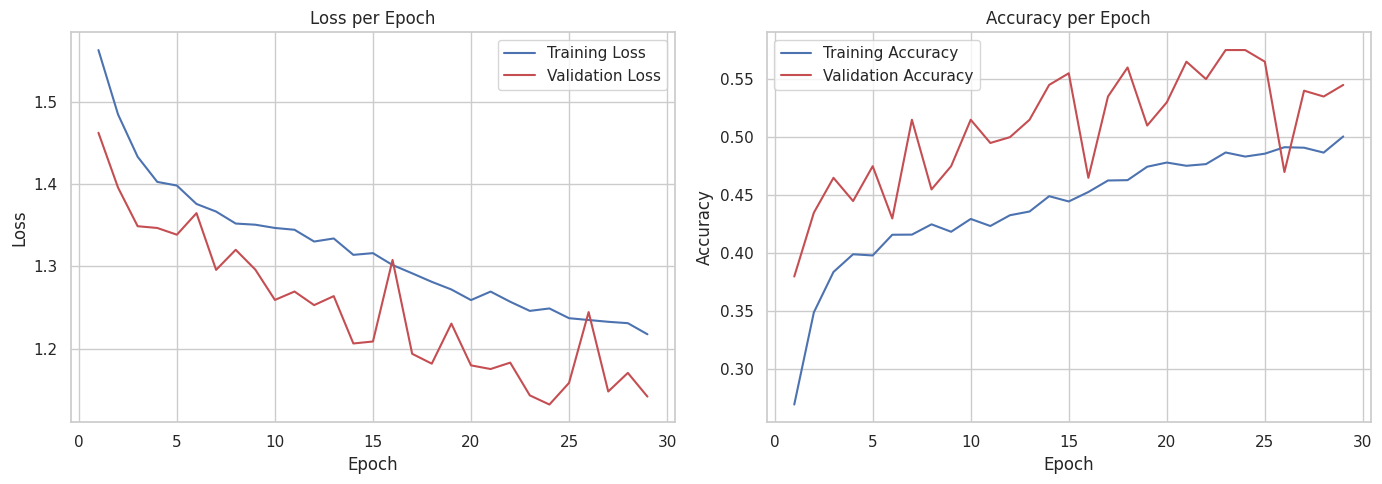

In [12]:
# Plot training history
plot_training_history(history)


Test Metrics:
Accuracy:   0.6200
Precision:  0.6292
Recall:     0.6200
F1 Score:   0.5799

Classification Report:
              precision    recall  f1-score   support

       Apple     0.4286    0.1500    0.2222        20
      Banana     0.6129    0.9500    0.7451        20
       Grape     0.6800    0.8500    0.7556        20
       Mango     0.8889    0.4000    0.5517        20
  Strawberry     0.5357    0.7500    0.6250        20

    accuracy                         0.6200       100
   macro avg     0.6292    0.6200    0.5799       100
weighted avg     0.6292    0.6200    0.5799       100



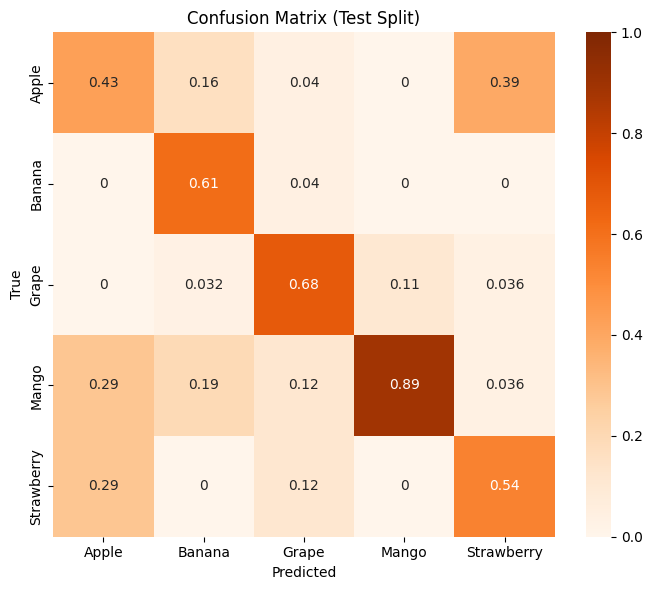

In [13]:
# Final test evaluation
evaluate_on_test(model, test_loader, device=device, class_names=train_dataset.classes)

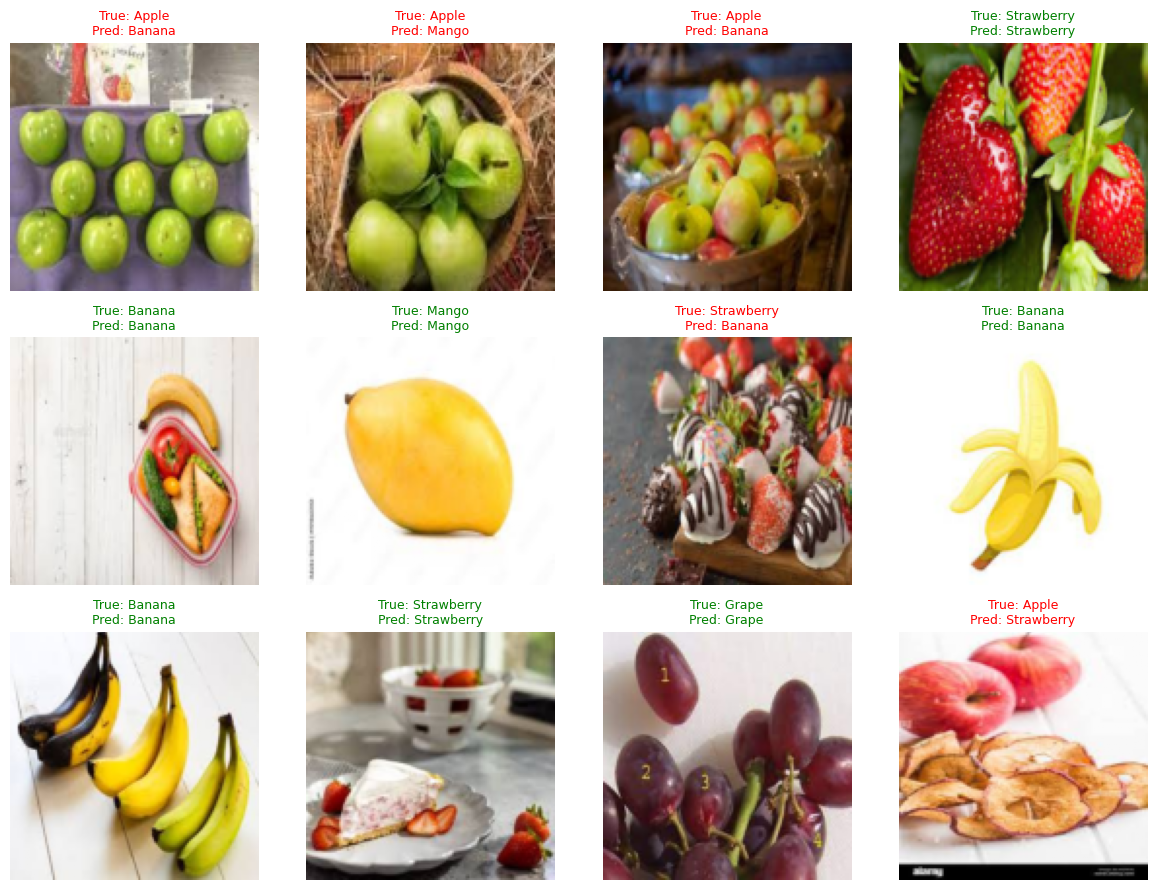

In [281]:
show_random_test_predictions(model, val_loader, device, class_names=test_dataset.classes)

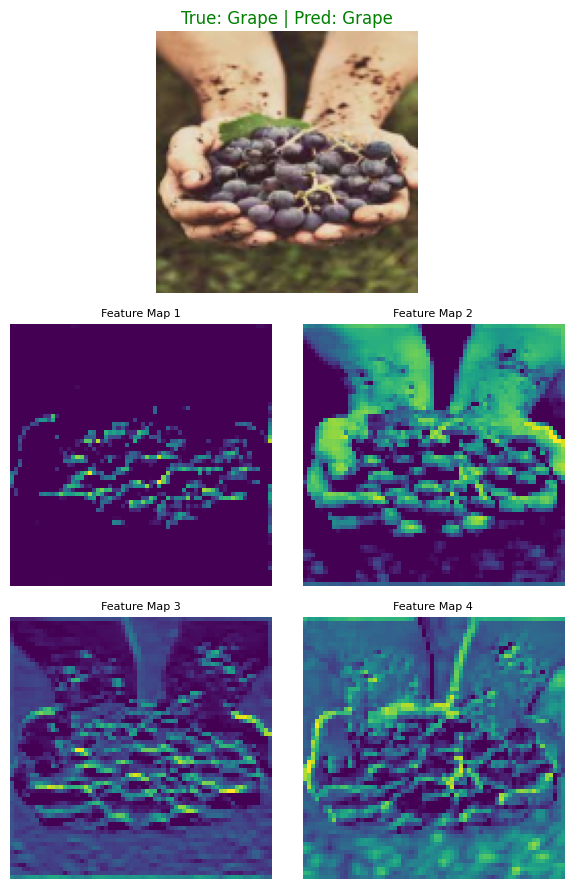

In [285]:
images, labels = next(iter(test_loader)) 
idx = random.randint(0, images.size(0) - 1)
img = images[idx]
label = labels[idx]

extract_and_show_features_with_prediction(model, img, label, device, class_names=test_dataset.classes)

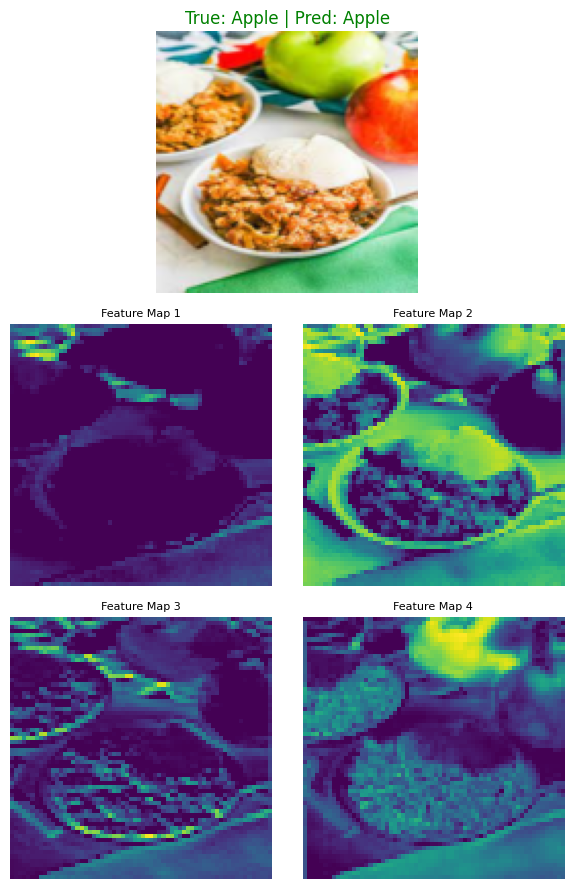

In [286]:
images, labels = next(iter(test_loader)) 
idx = random.randint(0, images.size(0) - 1)
img = images[idx]
label = labels[idx]

extract_and_show_features_with_prediction(model, img, label, device, class_names=test_dataset.classes)

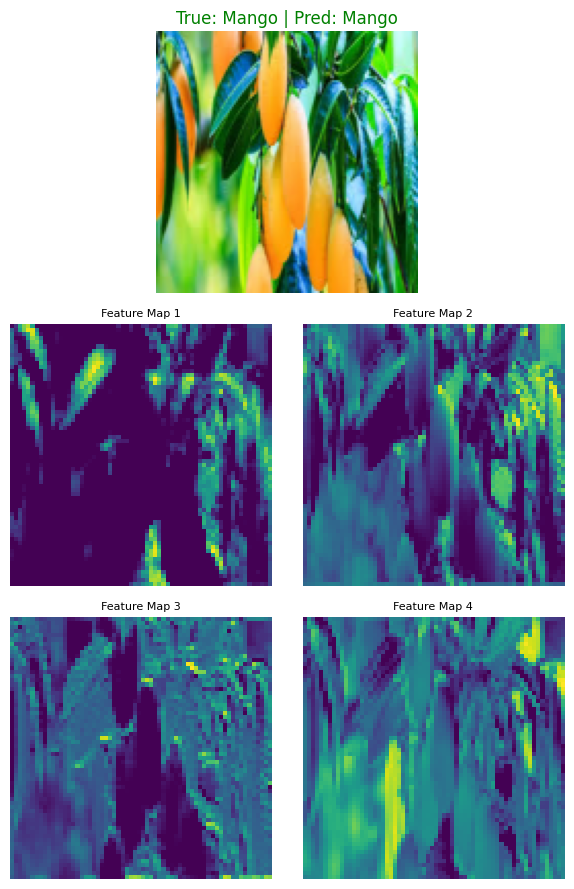

In [288]:
images, labels = next(iter(test_loader)) 
idx = random.randint(0, images.size(0) - 1)
img = images[idx]
label = labels[idx]

extract_and_show_features_with_prediction(model, img, label, device, class_names=test_dataset.classes)

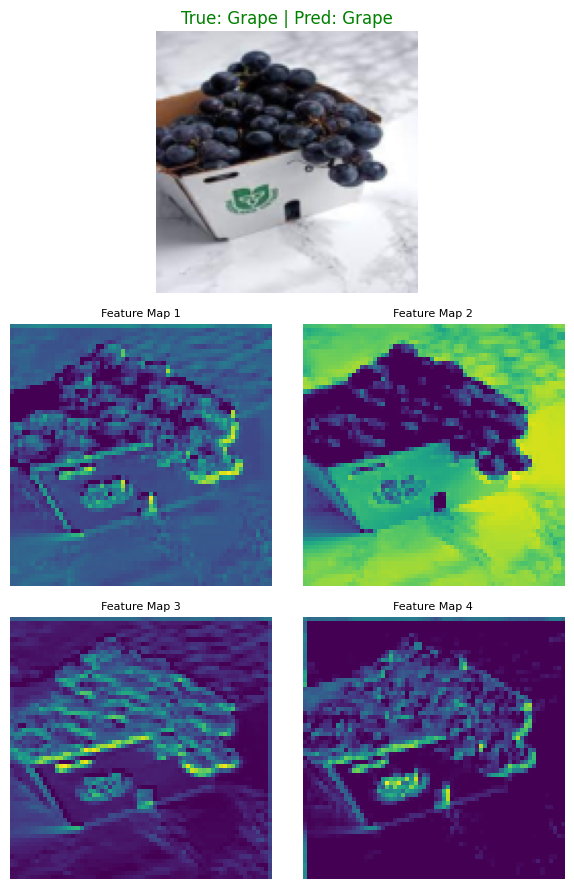

In [289]:
images, labels = next(iter(test_loader)) 
idx = random.randint(0, images.size(0) - 1)
img = images[idx]
label = labels[idx]

extract_and_show_features_with_prediction(model, img, label, device, class_names=test_dataset.classes)

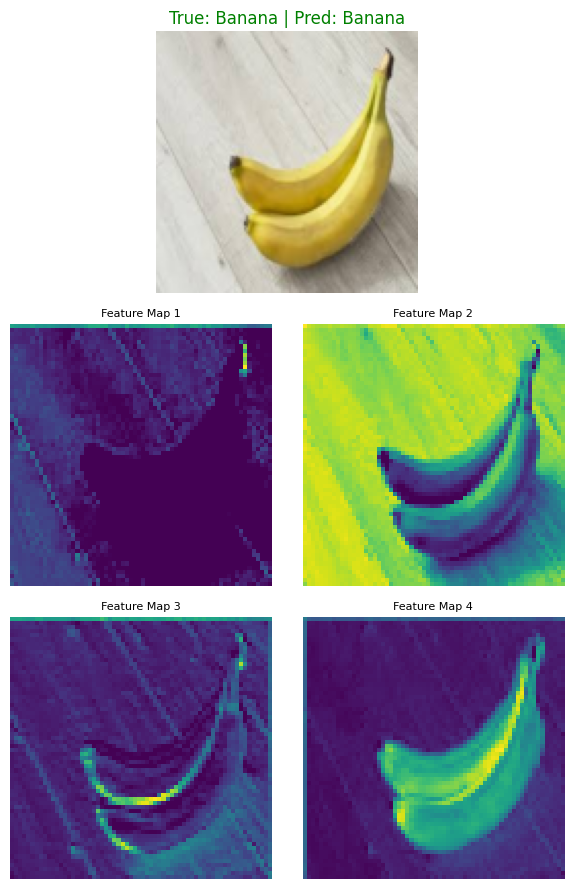

In [292]:
images, labels = next(iter(test_loader)) 
idx = random.randint(0, images.size(0) - 1)
img = images[idx]
label = labels[idx]

extract_and_show_features_with_prediction(model, img, label, device, class_names=test_dataset.classes)